### 1. 트랜스포머와 비교해 변경이 필요한 부분을 서술하였다. ###
    
1. 전처리 처리 
2. 인코더분리 및 제거
3. 

### 2. 모델의 입력 형태에 맞게 전처리를 수행하였다. ###

QA를 한입력으로 만들었다 단
<BOS> + Q + <ANS> + A + <EOS>
<ANS>를 이용해 출력을 구분할 수 있도록 하였다.
loss에 사용할 라벨도 <BOS> +<Q>까지 패딩으로 설정해 구성하였다.

### 3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다. ###

LearnedPositionalEmbedding 클래스를 새로 구성하여서 수정하였다.

### 4. GPT모델을 정상적으로 구성하였다. ###

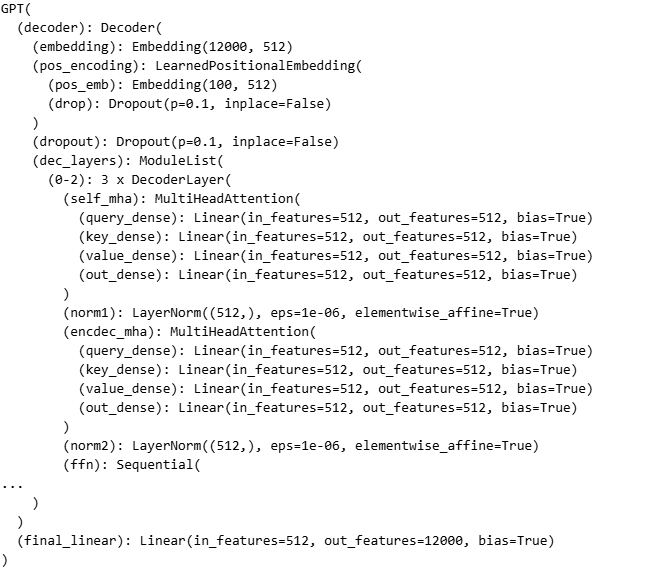
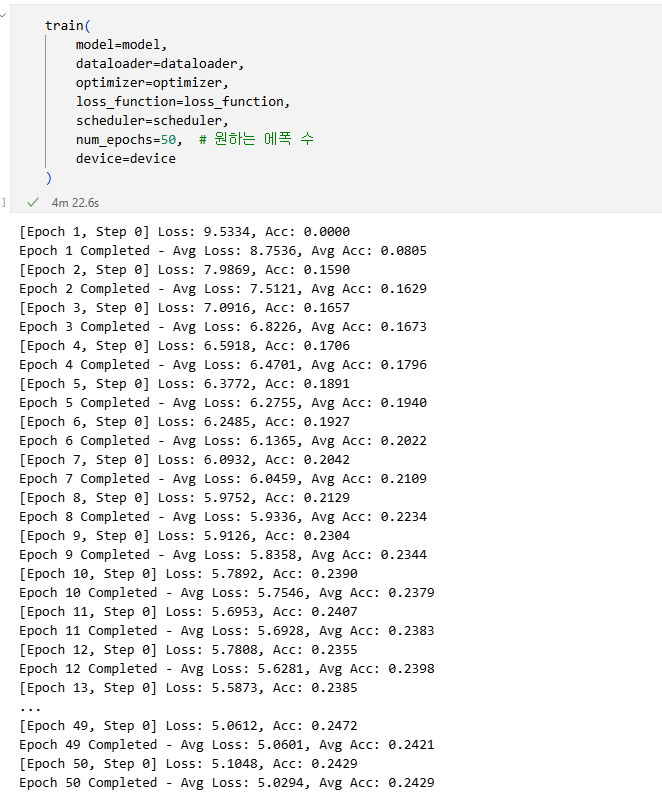

### 5. 입력에 따른 출력이 생성되었다. ###

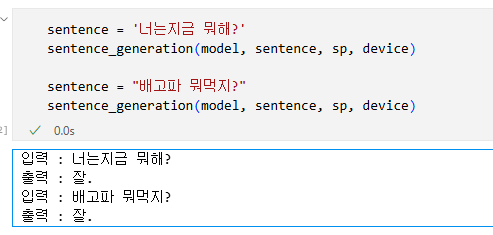

In [93]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len: int, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.pos_emb = nn.Embedding(max_seq_len, d_model)  # ★ 학습됨
        self.drop = nn.Dropout(dropout)


    def forward(self, x, attention_mask=None, past_length: int = 0):
        """
        x: (B, T, d_model) 전에 token embedding 적용된 텐서
        attention_mask: (B, T) 1=유효토큰, 0=PAD (없으면 단순 0..T-1)
        past_length: 생성 시 KV 캐시 길이 (오토리그레시브 이어쓰기)
        """
        B, T, _ = x.size()

        if attention_mask is None:
            position_ids = self.position_ids_base[:, :T] + past_length  # (1, T)
        else:
            # PAD가 섞였을 때: 유효 토큰만 순차 증가
            # ex) [0,1,1,1,0] -> cumsum-1 -> [-1,0,1,2,-1] -> clamp
            pos = (attention_mask.cumsum(dim=1) - 1).clamp(min=0) + past_length  # (B, T)
            position_ids = pos

        x = x + self.pos_emb(position_ids)  # 토큰 임베딩에 더하기
        return self.drop(x)

In [95]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [96]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


In [97]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, look_ahead_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out1 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3
    
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1,
                 max_seq_len=100):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = LearnedPositionalEmbedding(max_seq_len, d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, look_ahead_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, look_ahead_mask)

        return x

In [98]:
data = pd.read_csv("C:\\Users\\tkdwl\\AIFFEL_quest_rs\\Exploration\\Ex07\\datas\\ChatbotData.csv")
data.drop(["label"], axis=1,inplace=True)

def clean_korean(text):
    # 한글, 공백만 남기기
    text = re.sub(r'[^가-힣0-9\s!?,\.]', '', str(text))
    # 연속 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Q, A 컬럼 전처리
data['Q'] = data['Q'].apply(clean_korean)
data['A'] = data['A'].apply(clean_korean)

print(data.head())

                 Q            A
0           12시 땡!   하루가 또 가네요.
1      1지망 학교 떨어졌어    위로해 드립니다.
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.
4              심하네   눈살이 찌푸려지죠.


In [99]:
corpus_file = "clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in zip(data["Q"], data["A"]):
        f.write(q + "\n")
        f.write(a + "\n")

vocab_size = 12000
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="korean_chatbot_spm",
    vocab_size=vocab_size,
    character_coverage=1.0,
    model_type="bpe",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3,   # Unknown Token ID 설정
    user_defined_symbols=["<ANS>"]
)

sp = spm.SentencePieceProcessor()
sp.Load("korean_chatbot_spm.model")

# 예제 문장
sentence = " 3박4일 정도 놀러가고 싶다" + sp.IdToPiece(4) + "놀러가자"

sentence = clean_korean(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 3박4일 정도 놀러가고 싶다놀러가자
Tokenized: ['▁3', '박', '4', '일', '▁정도', '▁놀러가고', '▁싶다', '놀', '러가', '자']
Encoded: [471, 11295, 11263, 10838, 980, 3487, 199, 11049, 2064, 10811]
Decoded: 3박4일 정도 놀러가고 싶다놀러가자


In [100]:
print(sp.IdToPiece(4))

<ANS>


In [101]:
class KoDataset(Dataset):
    def __init__(self, pairs, sp, max_length=60):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            tokens = [bos_id] + q_ids + [4] + a_ids + [eos_id]
            label = [0] * len(q_ids) + [4] + a_ids + [eos_id]
            # 3) 길이 제한

            if len(tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            tokens += [0]*(max_length - len(tokens))
            label += [0]*(max_length - len(label)-1)
            # 5) GPT입력 
            dec_input = tokens[:-1]
            target = tokens[1:]

            self.data.append({
                "dec_input": dec_input,
                "target": target,
                "label": label
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        label = torch.tensor(sample["label"], dtype=torch.long)
        return  dec_input, target, label

In [102]:
class GPT(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1,
                 max_seq_len=100 ):
        super(GPT, self).__init__()

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함
    def create_padding_mask(self, x):
        # x == 0 위치를 찾아 float형 1로 변환
        mask = (x == 0).float()
        # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
        mask = mask.unsqueeze(1).unsqueeze(2)
        return mask
    def create_look_ahead_mask(self, x):
        seq_len = x.size(1)

        # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
        # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
        # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
        look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

        # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
        padding_mask = self.create_padding_mask(x)

        # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
        look_ahead_mask = look_ahead_mask.unsqueeze(0)
        # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
        look_ahead_mask = look_ahead_mask.unsqueeze(1)
        look_ahead_mask = look_ahead_mask.to(x.device)

        # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
        # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
        combined_mask = torch.max(look_ahead_mask, padding_mask)
        return combined_mask
    
    def forward(self, dec_inputs):
        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = self.create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)




        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            look_ahead_mask=look_ahead_mask,
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [103]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 3     # 인코더/디코더 층 수
D_MODEL = 512      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = vocab_size # 단어 집합 크기(예시)
BATCH_SIZE = 512
MAX_LENGTH = 80    # 최대 문장 길이
dataset = KoDataset(zip(data["Q"], data["A"]), sp, max_length=MAX_LENGTH)
dataloader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)
# 모델 생성
model = GPT(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_seq_len=MAX_LENGTH
)

print(model)

GPT(
  (decoder): Decoder(
    (embedding): Embedding(12000, 512)
    (pos_encoding): LearnedPositionalEmbedding(
      (pos_emb): Embedding(100, 512)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (dec_layers): ModuleList(
      (0-2): 3 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, bias=True)
          (out_dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (encdec_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, b

In [104]:
input, tgt, label =dataset[0]

print("Input shape:", input.shape)
print("Target shape:", tgt.shape)
print("Label shape:", label.shape)

Input shape: torch.Size([79])
Target shape: torch.Size([79])
Label shape: torch.Size([79])


In [105]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [106]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

In [107]:
# 하이퍼파라미터 설정
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝


In [108]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9, lr=2e-3)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=5))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [109]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    input, target, label = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), label)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [110]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [111]:
train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=50,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 9.5334, Acc: 0.0000
Epoch 1 Completed - Avg Loss: 8.7536, Avg Acc: 0.0805
[Epoch 2, Step 0] Loss: 7.9869, Acc: 0.1590
Epoch 2 Completed - Avg Loss: 7.5121, Avg Acc: 0.1629
[Epoch 3, Step 0] Loss: 7.0916, Acc: 0.1657
Epoch 3 Completed - Avg Loss: 6.8226, Avg Acc: 0.1673
[Epoch 4, Step 0] Loss: 6.5918, Acc: 0.1706
Epoch 4 Completed - Avg Loss: 6.4701, Avg Acc: 0.1796
[Epoch 5, Step 0] Loss: 6.3772, Acc: 0.1891
Epoch 5 Completed - Avg Loss: 6.2755, Avg Acc: 0.1940
[Epoch 6, Step 0] Loss: 6.2485, Acc: 0.1927
Epoch 6 Completed - Avg Loss: 6.1365, Avg Acc: 0.2022
[Epoch 7, Step 0] Loss: 6.0932, Acc: 0.2042
Epoch 7 Completed - Avg Loss: 6.0459, Avg Acc: 0.2109
[Epoch 8, Step 0] Loss: 5.9752, Acc: 0.2129
Epoch 8 Completed - Avg Loss: 5.9336, Avg Acc: 0.2234
[Epoch 9, Step 0] Loss: 5.9126, Acc: 0.2304
Epoch 9 Completed - Avg Loss: 5.8358, Avg Acc: 0.2344
[Epoch 10, Step 0] Loss: 5.7892, Acc: 0.2390
Epoch 10 Completed - Avg Loss: 5.7546, Avg Acc: 0.2379
[Epoch 11, Step 0]

In [130]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = clean_korean(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [4]
    # 차원 확장: (batch_size=1, seq_len)
    input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)



    model.eval()  # 모델 평가 모드
    processed_out = torch.empty(0,dtype=torch.long).to(device)
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            input = torch.cat([input, predicted_id], dim=1)
            processed_out = torch.cat([processed_out, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = processed_out.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [131]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [132]:
sentence = '너는지금 뭐해?'
sentence_generation(model, sentence, sp, device)

sentence = "배고파 뭐먹지?"
sentence_generation(model, sentence, sp, device)

입력 : 너는지금 뭐해?
출력 : 잘.
입력 : 배고파 뭐먹지?
출력 : 잘.


'잘.'